# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/erik/Code/Skola/ID2223/mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 13, 16, 9, 55, 197476)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-13 16:09:55,224 INFO: Initializing external client
2025-11-13 16:09:55,225 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-13 16:09:55,892 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-13 16:09:56,947 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279161


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=3
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-13 16:10:01,885 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/513328 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/126482 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26327 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.1888528E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [ ]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
airquality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)
# filter out to yesterday row
yesterday_data = airquality_fg.read()
# order by date descending
yesterday_data = yesterday_data.sort_values(by='date', ascending=False)
yesterday_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 


,date,pm25,country,city,street,url,lag_1_pm25,lag_2_pm25,lag_3_pm25
2136,2025-11-13 00:00:00+00:00,1.21,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,3.93,2.85,2.30
2137,2025-11-12 00:00:00+00:00,3.93,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,2.85,2.30,4.07
2139,2025-11-11 00:00:00+00:00,2.85,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,2.30,4.07,13.27
2138,2025-11-10 00:00:00+00:00,2.30,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,4.07,13.27,5.43
2140,2025-11-09 00:00:00+00:00,4.07,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,13.27,5.43,7.85
...,...,...,...,...,...,...,...,...,...
800,2020-01-04 00:00:00+00:00,0.55,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,0.74,6.30,1.37
353,2020-01-03 00:00:00+00:00,0.74,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,6.30,1.37,0.56
1137,2020-01-02 00:00:00+00:00,6.30,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,1.37,0.56,3.15
868,2020-01-01 00:00:00+00:00,1.37,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,0.56,3.15,8.19


In [8]:


# get the lagging features from air_quality feature group for the first row
batch_data = weather_fg.filter(weather_fg.date >= today).read()
# order by date
batch_data = batch_data.sort_values(by='date')
# add lag_1_pm25 to the first row as pm25 from date before in air
batch_data.loc[batch_data.index[0], 'lag_1_pm25'] = yesterday_data.loc[yesterday_data.index[0], 'pm25']
batch_data.loc[batch_data.index[0], 'lag_2_pm25'] = yesterday_data.loc[yesterday_data.index[0], 'lag_1_pm25']
batch_data.loc[batch_data.index[0], 'lag_3_pm25'] = yesterday_data.loc[yesterday_data.index[0], 'lag_2_pm25']

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.57s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1_pm25,lag_2_pm25,lag_3_pm25
5,2025-11-14 00:00:00+00:00,3.10,0.0,12.313893,285.255157,Vendelsö,1.21,3.93,2.85
1,2025-11-15 00:00:00+00:00,1.55,0.0,12.849528,258.690094,Vendelsö,NaN,NaN,NaN
4,2025-11-16 00:00:00+00:00,2.95,0.0,10.495713,239.036301,Vendelsö,NaN,NaN,NaN
3,2025-11-17 00:00:00+00:00,0.25,0.0,10.233123,320.710602,Vendelsö,NaN,NaN,NaN
0,2025-11-18 00:00:00+00:00,-0.70,0.0,13.049689,294.443939,Vendelsö,NaN,NaN,NaN
2,2025-11-19 00:00:00+00:00,1.10,0.5,13.004922,41.633450,Vendelsö,NaN,NaN,NaN


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [ ]:

# predict the first row
batch_data['predicted_pm25'] = 0.0  # Initialize the column
batch_data['predicted_pm25'].iloc[0] = retrieved_xgboost_model.predict(
    batch_data[['lag_1_pm25', 'lag_2_pm25', 'lag_3_pm25', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']].iloc[0].values.reshape(1, -1)
)
for i in range(1, len(batch_data)):
    # set lag features from previous row's actual and predicted pm25
    batch_data.loc[batch_data.index[i], 'lag_1_pm25'] = batch_data['predicted_pm25'].iloc[i-1]
    batch_data.loc[batch_data.index[i], 'lag_2_pm25'] = batch_data['lag_1_pm25'].iloc[i-1]
    batch_data.loc[batch_data.index[i], 'lag_3_pm25'] = batch_data['lag_2_pm25'].iloc[i-1]
    batch_data['predicted_pm25'].iloc[i] = retrieved_xgboost_model.predict(
        batch_data[['lag_1_pm25', 'lag_2_pm25', 'lag_3_pm25', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']].iloc[i].values.reshape(1, -1)
    )


batch_data

2025-11-13 16:10:10,810 WARNING: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2025-11-13 16:10:10,811 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1_pm25,lag_2_pm25,lag_3_pm25,predicted_pm25
5,2025-11-14 00:00:00+00:00,3.10,0.0,12.313893,285.255157,Vendelsö,1.210000,3.930000,2.850000,1.566219
1,2025-11-15 00:00:00+00:00,1.55,0.0,12.849528,258.690094,Vendelsö,1.566219,1.210000,3.930000,2.802227
4,2025-11-16 00:00:00+00:00,2.95,0.0,10.495713,239.036301,Vendelsö,2.802227,1.566219,1.210000,5.179532
3,2025-11-17 00:00:00+00:00,0.25,0.0,10.233123,320.710602,Vendelsö,5.179532,2.802227,1.566219,6.998472
0,2025-11-18 00:00:00+00:00,-0.70,0.0,13.049689,294.443939,Vendelsö,6.998472,5.179532,2.802227,2.427740
2,2025-11-19 00:00:00+00:00,1.10,0.5,13.004922,41.633450,Vendelsö,2.427740,6.998472,5.179532,2.303528


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 5 to 2
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   lag_1_pm25                   6 non-null      float32                
 7   lag_2_pm25                   6 non-null      float32                
 8   lag_3_pm25                   6 non-null      float32                
 9   predicted_pm25               6 non-null      float64                
dtypes: datetime

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [11]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1_pm25,lag_2_pm25,lag_3_pm25,predicted_pm25,street,country,days_before_forecast_day
5,2025-11-14 00:00:00+00:00,3.10,0.0,12.313893,285.255157,Vendelsö,1.210000,3.930000,2.850000,1.566219,Myggvägen,Sweden,1
1,2025-11-15 00:00:00+00:00,1.55,0.0,12.849528,258.690094,Vendelsö,1.566219,1.210000,3.930000,2.802227,Myggvägen,Sweden,2
4,2025-11-16 00:00:00+00:00,2.95,0.0,10.495713,239.036301,Vendelsö,2.802227,1.566219,1.210000,5.179532,Myggvägen,Sweden,3
3,2025-11-17 00:00:00+00:00,0.25,0.0,10.233123,320.710602,Vendelsö,5.179532,2.802227,1.566219,6.998472,Myggvägen,Sweden,4
0,2025-11-18 00:00:00+00:00,-0.70,0.0,13.049689,294.443939,Vendelsö,6.998472,5.179532,2.802227,2.427740,Myggvägen,Sweden,5
2,2025-11-19 00:00:00+00:00,1.10,0.5,13.004922,41.633450,Vendelsö,2.427740,6.998472,5.179532,2.303528,Myggvägen,Sweden,6


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 5 to 2
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   lag_1_pm25                   6 non-null      float32                
 7   lag_2_pm25                   6 non-null      float32                
 8   lag_3_pm25                   6 non-null      float32                
 9   predicted_pm25               6 non-null      float64                
 10  street     

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-13 16:10:10,910 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



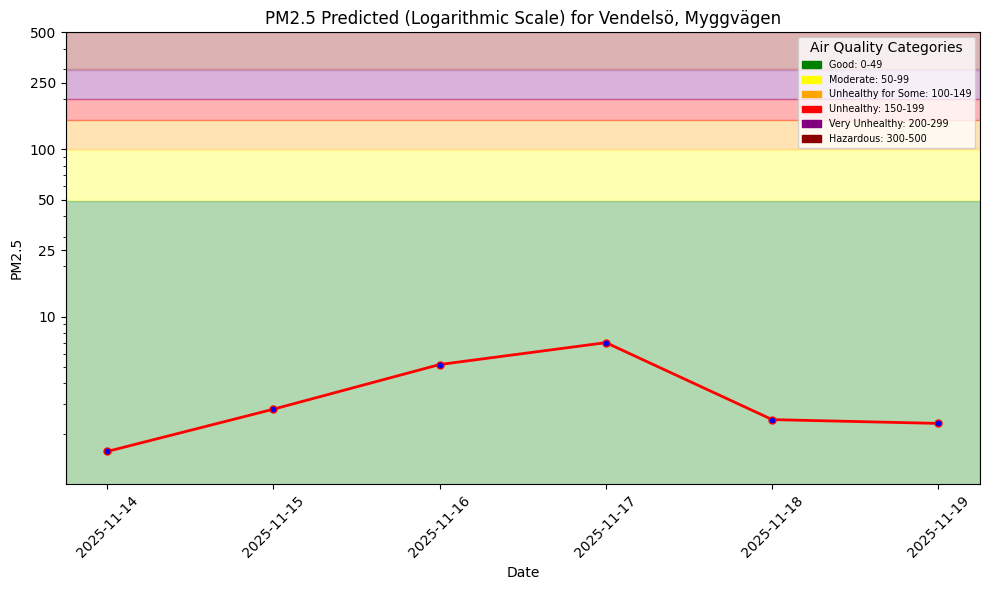

In [13]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [14]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [15]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279161/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-13 16:10:28,625 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-13 16:10:31,816 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-13 16:12:40,972 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-13 16:12:41,153 INFO: Waiting for log aggregation to finish.
2025-11-13 16:12:59,918 INFO: Execution finished successfully.


(Job('aq_predictions_2_offline_fg_materialization', 'SPARK'), None)

In [16]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.08s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1_pm25,lag_2_pm25,lag_3_pm25,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-14 00:00:00+00:00,3.1,0.0,12.313893,285.255157,Vendelsö,1.21,3.93,2.85,1.566219,Myggvägen,Sweden,1


In [17]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=2)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.98s) 


,date,pm25,country,city,street,url,lag_1_pm25,lag_2_pm25,lag_3_pm25
0,2020-12-31 00:00:00+00:00,4.48,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,1.37,6.29,6.40
1,2021-08-27 00:00:00+00:00,4.30,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,3.90,0.70,1.40
2,2023-02-06 00:00:00+00:00,2.63,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,1.92,1.27,1.60
3,2023-04-10 00:00:00+00:00,3.60,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,2.49,1.20,2.80
4,2024-10-12 00:00:00+00:00,1.50,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,0.90,4.09,4.98
...,...,...,...,...,...,...,...,...,...
2136,2025-11-13 00:00:00+00:00,1.21,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,3.93,2.85,2.30
2137,2025-11-12 00:00:00+00:00,3.93,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,2.85,2.30,4.07
2138,2025-11-10 00:00:00+00:00,2.30,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,4.07,13.27,5.43
2139,2025-11-11 00:00:00+00:00,2.85,Sweden,Vendelsö,Myggvägen,https://api.waqi.info/feed/A88876,2.30,4.07,13.27


In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.63s) 
                          date  temperature_2m_mean  precipitation_sum  \
1720 2019-12-31 00:00:00+00:00             2.937834                0.0   
621  2020-01-01 00:00:00+00:00             3.012833                0.0   
819  2020-01-02 00:00:00+00:00             5.150334                0.0   
934  2020-01-03 00:00:00+00:00             4.921167                0.0   
1    2020-01-04 00:00:00+00:00             1.492000                0.0   
...                        ...                  ...                ...   
2146 2025-11-15 00:00:00+00:00             1.550000                0.0   
2149 2025-11-16 00:00:00+00:00             2.950000                0.0   
2148 2025-11-17 00:00:00+00:00             0.250000                0.0   
2145 2025-11-18 00:00:00+00:00            -0.700000                0.0   
2147 2025-11-19 00:00:00+00:00             1.100000                0.5   

      wind_speed_10m_max 

Uploading Dataframe: 100.00% |██████████| Rows 4/4 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279161/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-13 16:13:23,500 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-13 16:13:42,767 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-13 16:16:35,957 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-13 16:16:36,125 INFO: Waiting for log aggregation to finish.
2025-11-13 16:17:05,160 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1_pm25,lag_2_pm25,lag_3_pm25,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2025-11-10 00:00:00+00:00,5.385750,1.4,7.938387,8.238893,Vendelsö,4.07,13.27,5.43,4.685641,2.30,Myggvägen,Sweden,1
1,2025-11-11 00:00:00+00:00,5.633667,0.0,9.983106,201.394379,Vendelsö,2.30,4.07,13.27,6.540112,2.85,Myggvägen,Sweden,1
2,2025-11-12 00:00:00+00:00,7.821167,4.3,27.388998,205.787766,Vendelsö,2.85,2.30,4.07,3.468040,3.93,Myggvägen,Sweden,1
3,2025-11-13 00:00:00+00:00,7.646166,4.1,19.758228,264.729736,Vendelsö,3.93,2.85,2.30,3.432233,1.21,Myggvägen,Sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

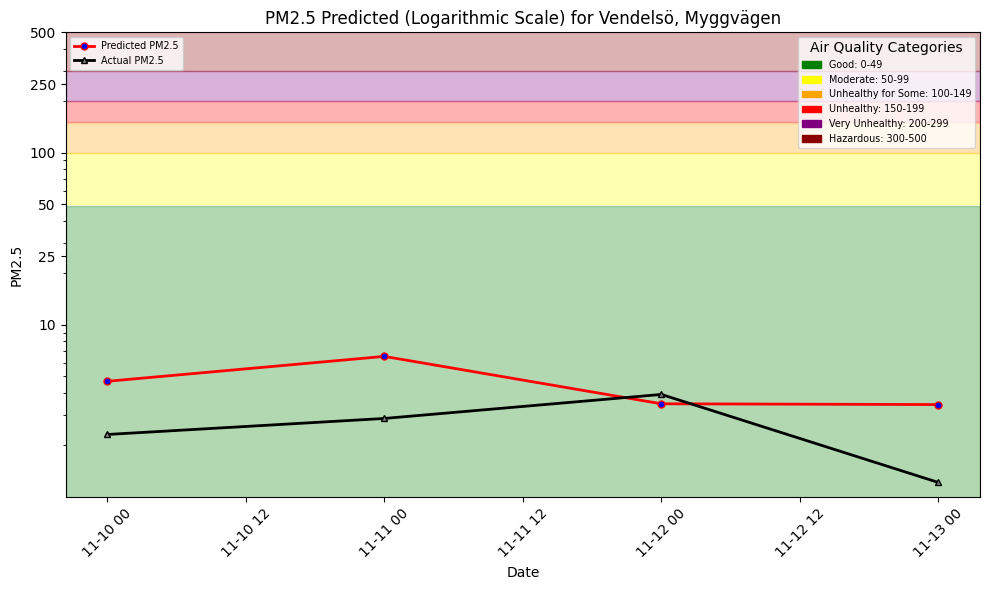

In [20]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [21]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|      …

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%| …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279161/settings/fb/path/Resources/airquality


---